# Global Mean Surface Temperature Anomalies (GMSTA) from CMIP6 data

---

## Overview
In this notebook we will compute the Global Mean Surface Temperature Anomalies (GMSTA) from CMIP6 data and compare it with observations. This notebook is heavily inspired by the [GMST example](https://projectpythia.org/cmip6-cookbook/notebooks/example-workflows/gmst/) in the CMIP6 cookbook and we thank the authors for their workflow.

1. We will get the CMIP6 temperature data from the AWS open data program via the us-west-2 origin
2. In order to do this, we will use an intake-ESM catalog (hosted on NCAR's RDA) that uses pelicanFS backed links instead of https or s3 links
3. We will grab observational data hosted on NCAR's RDA, which is accessible via the NCAR origin
4. Please refer to the first chapter of this cookbook to learn more about OSDF, pelican or pelicanFS
5. This notebook demonstrates that you can seamlessly stream data from multiple OSDF origins in your workflow


## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Intake-ESM](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | Used for searching CMIP6 data |
| [Understanding of Zarr](https://zarr.dev/) | Helpful | Familiarity with metadata structure |
| [Seaborn](https://seaborn.pydata.org/) | Helpful | Used for plotting|
| [PelicanFS](https://projectpythia.org/osdf-cookbook/notebooks/pelicanfs/) | Necessary | The python package used to stream data in this notebook |
| OSDF| Helpful | OSDF is used to stream data in this notebook |

- **Time to learn**: 20 mins

## Table of Contents
- [Set up local dask cluster](#Set-up-local-dask-Cluster) 
- [Data Loading](#Data-Loading) 
- [GMST computation](#GMST-Computation) 

## Imports

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
import aiohttp
import dask
from dask.distributed import LocalCluster
import pelicanfs 

/tmp/ipykernel_1732/2498615495.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


We will use an intake-ESM catalog hosted on NCAR's Research Data Archive. This is nothing but the AWS cmip6 catalog modified to use OSDF

In [2]:
# Load catalog URL
rda_url     =  'https://data.rda.ucar.edu/'
cat_url     = rda_url +  'd850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'
print(cat_url)

https://data.rda.ucar.edu/d850001/catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json


## Set up local dask cluster 

Before we do any computation let us first set up a local cluster using dask

In [1]:
cluster = LocalCluster()          
client = cluster.get_client()

NameError: name 'LocalCluster' is not defined

In [4]:
# Scale the cluster
n_workers = 5
cluster.scale(n_workers)
cluster

LocalCluster(652a9daa, 'tcp://127.0.0.1:35097', workers=4, threads=16, memory=15.16 GiB)

## Data Loading
### Load CMIP6 data from AWS 

In [5]:
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [7]:
# there is currently a significant amount of data for these runs
expts = ['historical', 'ssp245', 'ssp370']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
    #activity_id = 'CMIP',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset

,unique
activity_id,2
institution_id,20
source_id,27
experiment_id,3
member_id,1
table_id,1
variable_id,1
grid_label,3
zstore,81
dcpp_init_year,0


- Let us inspect the zarr store paths to see if we are using the pelican protocol.
- We see that zstore column has paths that start with 'osdf:///' instead of 'https://' which tells us that we are not using a simple 'https' GET request to fetch the data.
- In order to know more about the pelican protocol, please refer to the first chapter of this cookbook.

In [8]:
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
2,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
3,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20190529
4,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20190529
...,...,...,...,...,...,...,...,...,...,...,...
76,ScenarioMIP,NCC,NorESM2-MM,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
77,ScenarioMIP,NCC,NorESM2-MM,ssp245,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20191108
78,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20200623
79,ScenarioMIP,AS-RCEC,TaiESM1,ssp370,r1i1p1f1,Amon,tas,gn,osdf:///aws-opendata/us-west-2/cmip6-pds/CMIP6...,NaN,20201014


### Grab some Observational time series data for comparison with ensemble spread
- The observational data we will use is the HadCRUT5 dataset from the UK Met Office
- The data has been downloaded to NCAR's Research Data Archive (RDA) from https://www.metoffice.gov.uk/hadobs/hadcrut5/
- We will use an OSDF to access this copy from the RDA. Again the links will start with 'osdf:///'

In [9]:
%%time
obs_url    = 'osdf:///ncar/rda/d850001/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc'
#
obs_ds = xr.open_dataset(obs_url, engine='h5netcdf').tas_mean
obs_ds

CPU times: user 1.28 s, sys: 58.1 ms, total: 1.34 s
Wall time: 2.93 s


<xarray.DataArray 'tas_mean' (time: 2101)> Size: 17kB
[2101 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2025-01-1...
    latitude     float64 8B ...
    longitude    float64 8B ...
    realization  int64 8B ...
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

### Some helpful functions

In [10]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop_vars(drop_vars)

def open_dset(df):
    assert len(df) == 1
    mapper = fsspec.get_mapper(df.zstore.values[0])
    #path = df.zstore.values[0][7:]+".zmetadata"
    ds = xr.open_zarr(mapper, consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [11]:
dsets_ = dask.compute(dict(dsets))[0]

In [12]:
#calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [13]:
#calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

## GMST computation

In [14]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean).swap_dims({'time': 'year'})
                             .drop_vars('time').coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',dim=expt_da)

  0%|          | 0/27 [00:00<?, ?it/s]

In [15]:
%%time
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

CPU times: user 14.5 s, sys: 705 ms, total: 15.2 s
Wall time: 2min 31s


In [16]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset> Size: 167kB
Dimensions:        (source_id: 27, experiment_id: 3, year: 251)
Coordinates:
  * year           (year) float64 2kB 1.85e+03 1.851e+03 ... 2.099e+03 2.1e+03
  * experiment_id  (experiment_id) <U10 120B 'historical' 'ssp245' 'ssp370'
  * source_id      (source_id) <U16 2kB 'ACCESS-CM2' ... 'TaiESM1'
Data variables:
    tas            (source_id, experiment_id, year) float64 163kB 287.0 ... 2...

:::{hint}
Note that even though the variable is called tas, the DataArray big_ds actually has the global and annual mean of surface temperatures! If you are wondering why this is the case, take a look at all the functions that were applied to obtain dsets_ann_mean!
:::

In [17]:
# Compute annual mean temperatures anomalies of observational data
obs_gmsta = obs_ds.resample(time='YS').mean(dim='time')
# obs_gmsta

### Compute anomlaies and plot
- We will compute the temperature anomalies w.r.t 1960-1990 baseline period
- Convert xarray datasets to pandas dataframes
- Use Seaborn to plot GMSTA

In [18]:
df_all = big_ds.to_dataframe().reset_index()
df_all.head()

,source_id,experiment_id,year,tas
0,ACCESS-CM2,historical,1850.0,287.007494
1,ACCESS-CM2,historical,1851.0,287.016985
2,ACCESS-CM2,historical,1852.0,287.174542
3,ACCESS-CM2,historical,1853.0,287.070948
4,ACCESS-CM2,historical,1854.0,287.141159


In [19]:
# Define the baseline period
baseline_df = df_all[(df_all["year"] >= 1960) & (df_all["year"] <= 1990)]

# Compute the baseline mean
baseline_mean = baseline_df["tas"].mean()

# Compute anomalies
df_all["tas_anomaly"] = df_all["tas"] - baseline_mean
df_all

,source_id,experiment_id,year,tas,tas_anomaly
0,ACCESS-CM2,historical,1850.0,287.007494,-0.231968
1,ACCESS-CM2,historical,1851.0,287.016985,-0.222477
2,ACCESS-CM2,historical,1852.0,287.174542,-0.064920
3,ACCESS-CM2,historical,1853.0,287.070948,-0.168514
4,ACCESS-CM2,historical,1854.0,287.141159,-0.098303
...,...,...,...,...,...
20326,TaiESM1,ssp370,2096.0,291.798424,4.558962
20327,TaiESM1,ssp370,2097.0,291.854096,4.614635
20328,TaiESM1,ssp370,2098.0,292.141126,4.901664
20329,TaiESM1,ssp370,2099.0,292.206289,4.966827


In [20]:
obs_df = obs_gmsta.to_dataframe(name='tas_anomaly').reset_index()

In [21]:
# Convert 'time' to 'year' (keeping only the year)
obs_df['year'] = obs_df['time'].dt.year

# Drop the original 'time' column since we extracted 'year'
obs_df = obs_df[['year', 'tas_anomaly']]
obs_df

,year,tas_anomaly
0,1850,-0.417711
1,1851,-0.233350
2,1852,-0.229399
3,1853,-0.270354
4,1854,-0.291521
...,...,...
171,2021,0.761906
172,2022,0.801305
173,2023,1.100313
174,2024,1.180800


Almost there! Let us now use seaborn to plot all the anomalies

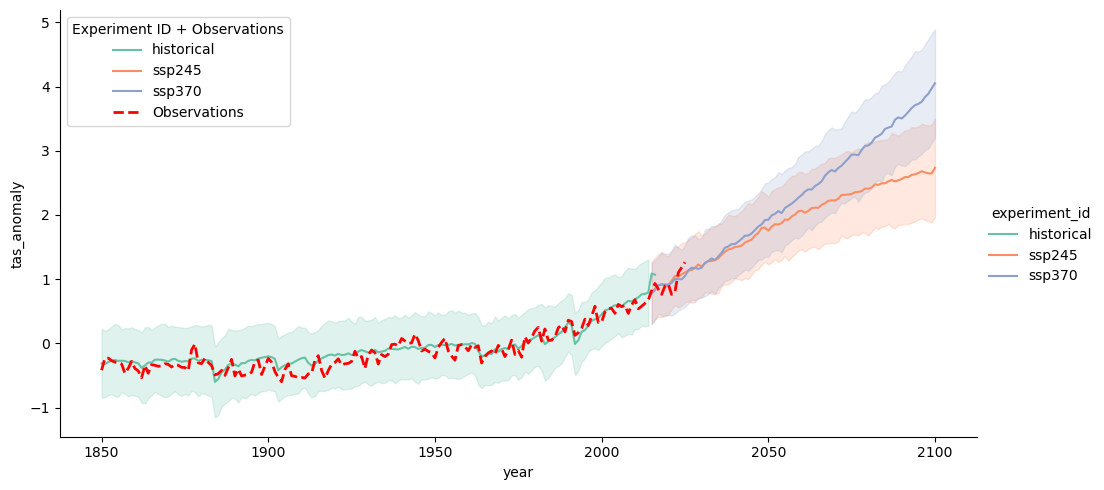

In [22]:
g = sns.relplot(data=df_all, x="year", y="tas_anomaly",
                hue='experiment_id', kind="line", errorbar="sd", aspect=2, palette="Set2")  # Adjust the color palette)

# Get the current axis from the FacetGrid
ax = g.ax

# Overlay the observational data in red
sns.lineplot(data=obs_df, x="year", y="tas_anomaly",color="red", 
             linestyle="dashed", linewidth=2,label="Observations", ax=ax)

# Adjust the legend to include observations
ax.legend(title="Experiment ID + Observations")

# Show the plot
plt.show()

---

## Summary
In this notebook, we used surface air temperature data from several CMIP6 models for the 'historical', 'SSP245' and 'SSP370' runs to compute Global Mean Surface Temperature Anomaly (GMSTA) relative to the 1960-1990 baseline period and compare it with anomalies computed from the HadCRUT monthly surface temperature dataset. We used a modified intake-ESM catalog and pelicanFS to 'stream/download' temperature data from two different OSDF origins. The CMIP6 model data was streamed from the AWS OpenData origin in the us-west-2 region and the observational data was streamed from NCAR's OSDF origin.

## Resources and references
1. [Original notebook](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html) in the Pangeo Gallery by Henri Drake and Ryan Abernathey
2. [CMIP6 cookbook](https://projectpythia.org/cmip6-cookbook/) by Ryan Abernathey, Henri Drake, Robert Ford and Max Grover
3. Coupled Model Intercomparison Project 6 was accessed from https://registry.opendata.aws/cmip6 using a modified intake-ESM catalog hosted on NCAR's RDA
4. We thank the UK Met Office Hadley Center for providing the observational data
